In [145]:
import os
import regex as re,string
from urllib import request 
from collections import defaultdict
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import pandas as pd

mpl.rcParams["font.size"] = 7
mpl.rcParams['figure.dpi'] = 120
%matplotlib notebook

In [4]:
def download_data(name_dir="data", filename="data.csv",
                  data_url = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2017/cities/totals/sub-est2017_42.csv'):
    """ 
    Download both train and test dataset to a directory named "data". 

    If the directory doesn't exist, this function will create one. 

    Parameters
    ----------
    url : str
    The URL of the location of the file.

    Returns
    -------
    No return. Create a directory if needed and 
    download the file to that directory.
    """
    
    if not os.path.isdir(name_dir):
        os.makedirs(name_dir)

    data_path = os.path.join(name_dir, filename)

    request.urlretrieve(data_url,data_path)
    
def GEOID_ten(x):
    """
    Convert 12-digit geoid to 10-digit.
    
    More details can be found at https://www.census.gov/geo/reference/geoidentifiers.html.
    Parameters
    ----------
    x : int
    
    Returns
    -------
    int
    
    """
    
    astr = str(x)[:10]
    return int(astr)

## Download Sub-county population dataset for PA

In [5]:
# https://www.census.gov/data/datasets/2017/demo/popest/total-cities-and-towns.html
url_pop = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2017/cities/totals/sub-est2017_42.csv'

In [6]:
download_data(name_dir="data", 
              filename="population.csv",
              data_url=url_pop)

## Download population data from US Census

In [7]:
url_ems = 'https://data.wprdc.org/dataset/abba9671-a026-4270-9c83-003a1414d628/resource/ff33ca18-2e0c-4cb5-bdcd-60a5dc3c0418/download/911-ems-dispatches.csv'

In [8]:
download_data(name_dir="data", 
              filename="EMS.csv",
              data_url=url_ems)

In [9]:
df_ems = pd.read_csv('data/EMS.csv')
df_ems.head()


,Call_ID_Hash,SERVICE,PRIORITY,PRIORITY_DESC,AGENCY,CALL_QUARTER,CALL_YEAR,DESCRIPTION_SHORT,CITY_CODE,CITY_NAME,GEOID
0,336ba345f5a0,EMS,E0,EMS ALS life threatening response w/ backup,E620,Q1,2015,HEMORRHAGE,PVU,PORT VUE,420035003002
1,f59d50d394fa,EMS,E0,EMS ALS life threatening response w/ backup,E380,Q1,2015,UNCONSCIOUS,PEN,PENN HILLS,420035235011
2,8d56b4f6f9fe,EMS,E0,EMS ALS life threatening response w/ backup,E620,Q1,2015,UNCONSCIOUS,MCK,MCKEESPORT,420035523003
3,e20045d2f6b4,EMS,E0,EMS ALS life threatening response w/ backup,E050,Q1,2015,"GUNSHOT, STABBING, OR OTHER WOUND",PGH,PITTSBURGH,420031306003
4,dbe1c9db46f6,EMS,E0,EMS ALS life threatening response w/ backup,E050,Q1,2015,ASSAULT,PGH,PITTSBURGH,420031609002


In [10]:
df_pop = pd.read_csv('data/population.csv')
df_pop.head()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017
0,40,42,0,0,0,0,0,A,Pennsylvania,Pennsylvania,12702379,12702857,12711063,12742811,12768034,12778450,12790341,12791124,12787085,12805537
1,162,42,0,116,0,0,0,A,Abbottstown borough,Pennsylvania,1011,1011,1010,1011,1008,1006,1009,1012,1013,1020
2,162,42,0,332,0,0,0,A,Adamsburg borough,Pennsylvania,172,172,172,171,170,169,168,167,165,164
3,162,42,0,364,0,0,0,A,Adamstown borough,Pennsylvania,1789,1789,1801,1835,1837,1839,1844,1845,1847,1850
4,162,42,0,396,0,0,0,A,Addison borough,Pennsylvania,207,207,207,205,204,202,201,198,198,197


In [40]:
df_pop['NAME_UP'] = df_pop['NAME'].str.upper() #  .str.replace('[^\w\s]','')
df_pop.head()


,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,...,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,NAME_UP
0,40,42,0,0,0,0,0,A,Pennsylvania,Pennsylvania,...,12702857,12711063,12742811,12768034,12778450,12790341,12791124,12787085,12805537,PENNSYLVANIA
1,162,42,0,116,0,0,0,A,Abbottstown borough,Pennsylvania,...,1011,1010,1011,1008,1006,1009,1012,1013,1020,ABBOTTSTOWN BOROUGH
2,162,42,0,332,0,0,0,A,Adamsburg borough,Pennsylvania,...,172,172,171,170,169,168,167,165,164,ADAMSBURG BOROUGH
3,162,42,0,364,0,0,0,A,Adamstown borough,Pennsylvania,...,1789,1801,1835,1837,1839,1844,1845,1847,1850,ADAMSTOWN BOROUGH
4,162,42,0,396,0,0,0,A,Addison borough,Pennsylvania,...,207,207,205,204,202,201,198,198,197,ADDISON BOROUGH


In [12]:
df_ems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780698 entries, 0 to 780697
Data columns (total 11 columns):
Call_ID_Hash         780698 non-null object
SERVICE              780698 non-null object
PRIORITY             780698 non-null object
PRIORITY_DESC        780698 non-null object
AGENCY               780698 non-null object
CALL_QUARTER         780698 non-null object
CALL_YEAR            780698 non-null int64
DESCRIPTION_SHORT    778103 non-null object
CITY_CODE            780634 non-null object
CITY_NAME            780611 non-null object
GEOID                780698 non-null int64
dtypes: int64(2), object(9)
memory usage: 65.5+ MB


In [13]:
def getCodeName(geoid,df):
    """
    Return city name and city code for a given geioid.
    
    Parameters
    ----------
    geoid : int
    df : DataFrame
    
    Returns
    -------
    tuple
    """
    temp = df[(df_ems.GEOID == geoid) & (df.CITY_NAME.notnull()) ][['CITY_CODE','CITY_NAME']]
    city_name = temp['CITY_NAME'].value_counts().index[0]
    city_code = temp[ temp['CITY_NAME'] == city_name]['CITY_CODE'].value_counts().index[0]
#     print(city_name,city_code)
    return city_name,city_code

def nested_dict():
  """
  This returns a empty nestable dictionary.
  """
  return defaultdict(nested_dict)




In [14]:
getCodeName(420035629002,df_ems)

('PITTSBURGH', 'PGH')

In [15]:
# Create a backup copy
df_ems_bk = df_ems.copy()

In [16]:
# Get index for missing values at CITY_CODE and CITY_NAME
index_for_missing_values = df_ems[(df_ems.CITY_NAME.isnull()) | (df_ems.CITY_CODE.isnull())].index.tolist()
index_for_missing_values[:10]

[7200, 7237, 29818, 45426, 51944, 69156, 104522, 104614, 107710, 114511]

In [17]:
# Fill the missing values
for index in index_for_missing_values:
    geoid = df_ems.loc[index,'GEOID']
    ct_name, ct_code = getCodeName(geoid,df_ems)
    
    df_ems.loc[index,'CITY_NAME'] = ct_name
    df_ems.loc[index,'CITY_CODE'] = ct_code

# Recheck missing at CITY_CODE and CITY_NAME
df_ems[(df_ems.CITY_NAME.isnull()) | (df_ems.CITY_CODE.isnull())].index.tolist()


[]

In [18]:
df_ems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780698 entries, 0 to 780697
Data columns (total 11 columns):
Call_ID_Hash         780698 non-null object
SERVICE              780698 non-null object
PRIORITY             780698 non-null object
PRIORITY_DESC        780698 non-null object
AGENCY               780698 non-null object
CALL_QUARTER         780698 non-null object
CALL_YEAR            780698 non-null int64
DESCRIPTION_SHORT    778103 non-null object
CITY_CODE            780698 non-null object
CITY_NAME            780698 non-null object
GEOID                780698 non-null int64
dtypes: int64(2), object(9)
memory usage: 65.5+ MB


In [19]:
df_ems[df_ems.DESCRIPTION_SHORT.isnull()]['PRIORITY_DESC'].value_counts()

EMS Admin Mark out                             2491
EMS Standard BLS response                        31
EMS ALS life threatening response                31
EMS Standard ALS response                        21
EMS ALS life threatening response w/ backup      12
EMS BLS Assistance response                       8
Fire Notifications                                1
Name: PRIORITY_DESC, dtype: int64

In [20]:
df_ems['DESCRIPTION_SHORT'].fillna('MISSING',inplace=True)

In [21]:
df_ems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780698 entries, 0 to 780697
Data columns (total 11 columns):
Call_ID_Hash         780698 non-null object
SERVICE              780698 non-null object
PRIORITY             780698 non-null object
PRIORITY_DESC        780698 non-null object
AGENCY               780698 non-null object
CALL_QUARTER         780698 non-null object
CALL_YEAR            780698 non-null int64
DESCRIPTION_SHORT    780698 non-null object
CITY_CODE            780698 non-null object
CITY_NAME            780698 non-null object
GEOID                780698 non-null int64
dtypes: int64(2), object(9)
memory usage: 65.5+ MB


In [22]:
ct_names = df_ems.CITY_NAME.unique().tolist()
ct_names[:10]

['PORT VUE',
 'PENN HILLS',
 'MCKEESPORT',
 'PITTSBURGH',
 'ROSS',
 'SOUTH FAYETTE',
 'FRANKLIN PARK',
 'DUQUESNE',
 'PITCAIRN',
 'WEST MIFFLIN']

In [23]:
# Check Westmoreland county in city names
df_ems[df_ems.CITY_NAME.isin(['WESTMORELAND COUNTY'])]

,Call_ID_Hash,SERVICE,PRIORITY,PRIORITY_DESC,AGENCY,CALL_QUARTER,CALL_YEAR,DESCRIPTION_SHORT,CITY_CODE,CITY_NAME,GEOID
211893,eb764b289f44,EMS,E1,EMS ALS life threatening response,E590,Q4,2015,COMMERCIAL OR APARTMENT BLDG FIRE,WST,WESTMORELAND COUNTY,420034961023


In [24]:
# Drop westmoreland county
print("No. of rows before dropping = ", len(df_ems))
df_ems.drop(df_ems[df_ems.CITY_NAME.isin(['WESTMORELAND COUNTY'])].index, inplace=True)
print("No. of rows after dropping = ", len(df_ems))

No. of rows before dropping =  780698
No. of rows after dropping =  780697


In [25]:
# Rebuild the city name list
ct_names = df_ems.CITY_NAME.unique().tolist()

In [26]:
df_pop.head()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,...,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,NAME_UP
0,40,42,0,0,0,0,0,A,Pennsylvania,Pennsylvania,...,12702857,12711063,12742811,12768034,12778450,12790341,12791124,12787085,12805537,PENNSYLVANIA
1,162,42,0,116,0,0,0,A,Abbottstown borough,Pennsylvania,...,1011,1010,1011,1008,1006,1009,1012,1013,1020,ABBOTTSTOWN BOROUGH
2,162,42,0,332,0,0,0,A,Adamsburg borough,Pennsylvania,...,172,172,171,170,169,168,167,165,164,ADAMSBURG BOROUGH
3,162,42,0,364,0,0,0,A,Adamstown borough,Pennsylvania,...,1789,1801,1835,1837,1839,1844,1845,1847,1850,ADAMSTOWN BOROUGH
4,162,42,0,396,0,0,0,A,Addison borough,Pennsylvania,...,207,207,205,204,202,201,198,198,197,ADDISON BOROUGH


In [171]:
temp_dict = nested_dict()

In [41]:
def get_pop(ct_name, df, name_col, yr_st, yr_end):
    columns=['POPESTIMATE{yr}'.format(yr=str(yr)) 
             for yr in range(yr_st, yr_end+1)]
    ct_ext = ['BOROUGH', 'CITY', 'TOWNSHIP', 'MUNICIPALITY']
    if ct_name.endswith(('BOROUGH', 'CITY', 'TOWNSHIP', 'BORO')):
        alist = ct_name.split()
        ct_name = ' '.join(alist[:-1])
    if 'CLAIR' in ct_name:
        ct_name = ct_name.replace('ST ', 'ST. ')
    ct_names = ['{name} {ext}'.format(name=ct_name, ext=ext) 
                for ext in ct_ext]
    return (df[(df[name_col]
                .isin(ct_names))][columns]
            .median().astype('int').tolist())
    

In [42]:
get_pop('SOUTH FAYETTE',df_pop,'NAME_UP',2015,2017)

[15423, 15511, 15614]

In [43]:
def get_pop_dict(ct_names, df, name_col, yr_st, yr_end):
    pop_dict = nested_dict()
    for ct_name in ct_names:
        try:
            pops = get_pop(ct_name, df, name_col, yr_st, yr_end)
            for yr,pop in zip(range(yr_st,yr_end+1), pops):
                pop_dict[ct_name][yr]=pop
        except ValueError:
            print(ct_name)
            return ct_name
    return pop_dict

In [44]:
pop_dict = get_pop_dict(ct_names,df_pop,'NAME_UP',2015,2017)
pop_dict

defaultdict(<function __main__.nested_dict()>,
            {'PORT VUE': defaultdict(<function __main__.nested_dict()>,
                         {2015: 3753, 2016: 3725, 2017: 3700}),
             'PENN HILLS': defaultdict(<function __main__.nested_dict()>,
                         {2015: 41875, 2016: 41563, 2017: 41291}),
             'MCKEESPORT': defaultdict(<function __main__.nested_dict()>,
                         {2015: 19509, 2016: 19369, 2017: 19245}),
             'PITTSBURGH': defaultdict(<function __main__.nested_dict()>,
                         {2015: 304453, 2016: 305017, 2017: 302407}),
             'ROSS': defaultdict(<function __main__.nested_dict()>,
                         {2015: 5774, 2016: 5763, 2017: 5805}),
             'SOUTH FAYETTE': defaultdict(<function __main__.nested_dict()>,
                         {2015: 15423, 2016: 15511, 2017: 15614}),
             'FRANKLIN PARK': defaultdict(<function __main__.nested_dict()>,
                         {2015: 14330,

In [158]:
def get_pop(x, **kwargs):
    pop_dict = kwargs['pop_dict']
    yr = kwargs['yr']
    return pop_dict[x][yr]

def get_call_per_city(df, pop_dict, yr):
    df_city_count =df[df['CALL_YEAR'] == yr]['CITY_NAME'].value_counts().reset_index()
    df_city_count.columns = ['CITY_NAME', 'NO. OF CALLS']
    df_city_count['PERCENTAGE OVER TOTAL CALLS'] = round(df_city_count['NO. OF CALLS']/
                                                         df_city_count['NO. OF CALLS'].sum()*
                                                         100,2)
    col_name = 'POPULATION'.format(yr=yr)
    df_city_count[col_name] = (df_city_count['CITY_NAME']
                               .apply(get_pop, pop_dict=pop_dict, yr = yr))
    
    df_city_count['CALL_PER_POP'] = (df_city_count['NO. OF CALLS']/
                                     df_city_count[col_name])
    # Sort the column
    df_city_count.sort_values(by=['CALL_PER_POP',col_name],
                              ascending=False,
                              inplace=True)
    
    return df_city_count
    
    

In [159]:
call_per_city_2015 = get_call_per_city(df_ems, pop_dict, 2015)
call_per_city_2015.head()

,CITY_NAME,NO. OF CALLS,PERCENTAGE OVER TOTAL CALLS,POPULATION,CALL_PER_POP
19,HARRISON,1823,0.97,1011,1.803165
43,PINE,1039,0.55,744,1.396505
24,ELIZABETH TOWNSHIP,1645,0.87,1504,1.093750
32,RICHLAND,1397,0.74,1567,0.891512
4,ROSS,4700,2.49,5774,0.813994


In [160]:
call_per_city_2016 = get_call_per_city(df_ems, pop_dict, 2016)
call_per_city_2016.head()

,CITY_NAME,NO. OF CALLS,PERCENTAGE OVER TOTAL CALLS,POPULATION,CALL_PER_POP
18,HARRISON,1995,1.02,1002,1.991018
50,PINE,991,0.51,743,1.333782
32,ELIZABETH TOWNSHIP,1490,0.76,1492,0.998660
4,ROSS,4755,2.44,5763,0.825091
37,RICHLAND,1251,0.64,1579,0.792274


In [161]:
call_per_city_2017 = get_call_per_city(df_ems, pop_dict, 2017)
call_per_city_2017.head()

,CITY_NAME,NO. OF CALLS,PERCENTAGE OVER TOTAL CALLS,POPULATION,CALL_PER_POP
19,HARRISON,1979,1.01,994,1.990946
43,PINE,1088,0.55,738,1.474255
30,ELIZABETH TOWNSHIP,1588,0.81,1482,1.071525
4,ROSS,4686,2.38,5805,0.807235
38,RICHLAND,1261,0.64,1594,0.791092


In [171]:
def Top_plot(df1, df2, df3, pop_cutoff=0, top=10):
    city_names = []
    for df in [df1,df2,df3]:
        city_names.extend(df1.iloc[:top,0].tolist())
    city_names = list(set(city_names))
    col_names = ['CITY_NAME', 'NO. OF CALLS', 
                 'POPULATION', 'CALL_PER_POP', 'YEAR']
    df_temp = pd.DataFrame(columns=col_names)
    for df, yr in zip([df1, df2, df3],[2015, 2016, 2017]):
        df['YEAR'] = yr
        df_temp = df_temp.append(df[(df['CITY_NAME'].isin(city_names))
                                    & (df.iloc[:,3] > pop_cutoff)][col_names]
                                 .sort_values(by=['CALL_PER_POP','NO. OF CALLS'],
                                 ascending=False))
         
    return df_temp
    

In [173]:
Top_20_df = Top_plot(call_per_city_2015, call_per_city_2016, call_per_city_2017,top=20)

In [176]:
def bar_plot(df,col_name='CALL_PER_POP'):
    plt.figure()
    sns.barplot(x='CITY_NAME', y=col_name, 
                hue='YEAR', data=df)
    plt.xticks(rotation=90)
    

<IPython.core.display.Javascript object>


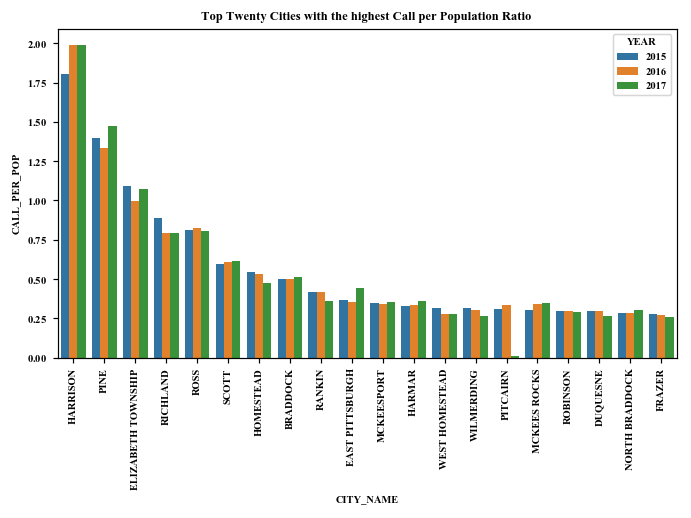

In [179]:
bar_plot(Top_20_df)
plt.title("Top Twenty Cities with the highest Call per Population Ratio ")
plt.tight_layout()

<IPython.core.display.Javascript object>


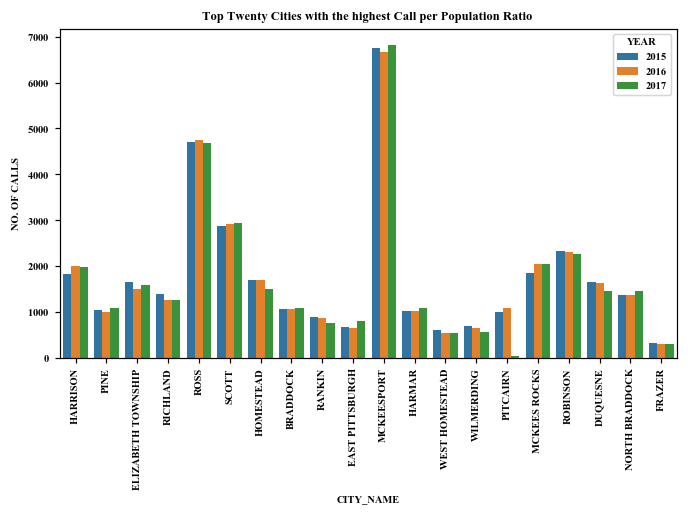

In [180]:
bar_plot(Top_20_df,'NO. OF CALLS')
plt.title("Top Twenty Cities with the highest Call per Population Ratio ")
plt.tight_layout()

<IPython.core.display.Javascript object>


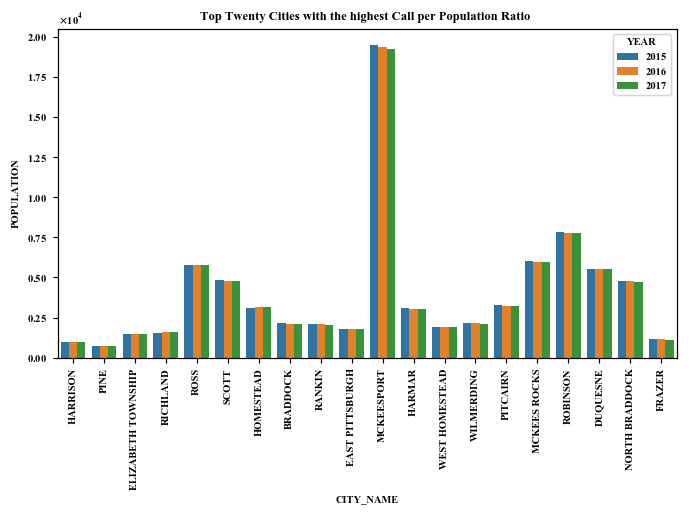

In [181]:
bar_plot(Top_Ten_df,'POPULATION')
plt.title("Top Twenty Cities with the highest Call per Population Ratio ")
plt.tight_layout()

In [216]:
Top_20_df_3000 = Top_plot(call_per_city_2015, 
                          call_per_city_2016, 
                          call_per_city_2017,
                          top=34,pop_cutoff=3000)

<IPython.core.display.Javascript object>


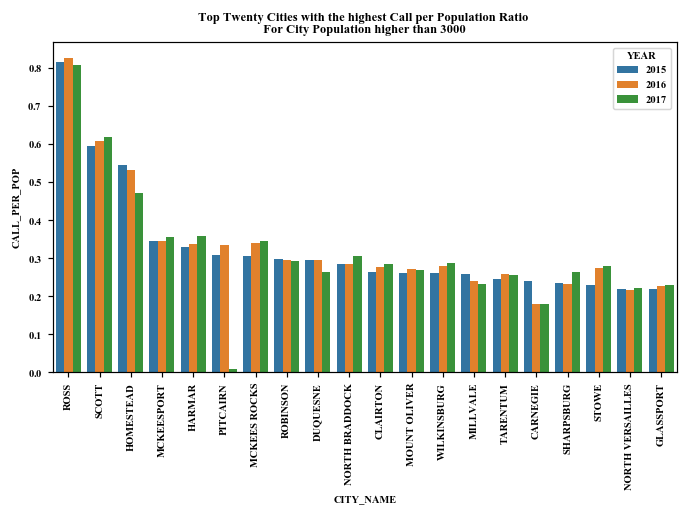

In [220]:
bar_plot(Top_20_df_3000)
plt.title("Top Twenty Cities with the highest Call per Population Ratio \n For City Population higher than 3000 ")
plt.tight_layout()

<IPython.core.display.Javascript object>


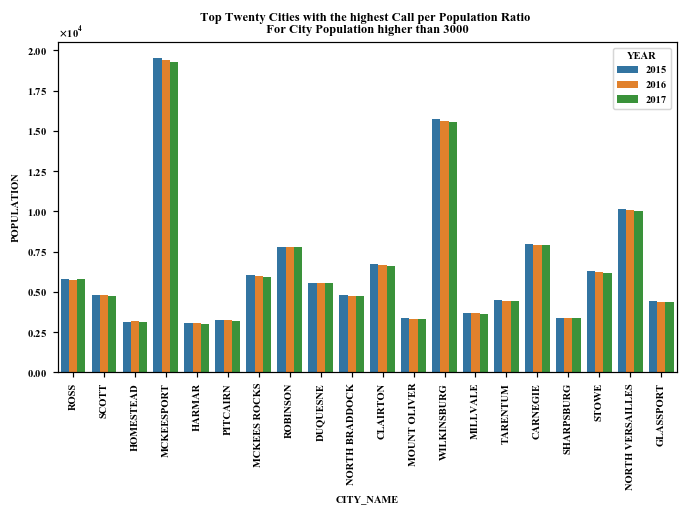

In [218]:
bar_plot(Top_20_df_3000,'POPULATION')
plt.title("Top Twenty Cities with the highest Call per Population Ratio \n For City Population higher than 3000 ")
plt.tight_layout()

<IPython.core.display.Javascript object>


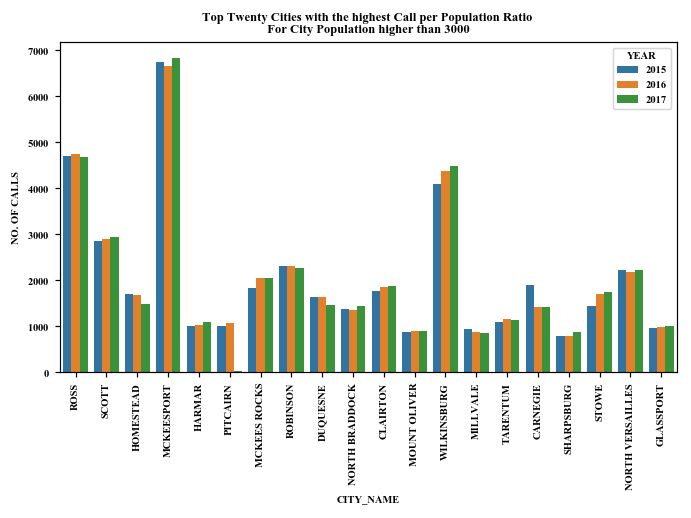

In [219]:
bar_plot(Top_20_df_3000, 'NO. OF CALLS')
plt.title("Top Twenty Cities with the highest Call per Population Ratio \n For City Population higher than 3000 ")
plt.tight_layout()